# Output generation

Recall the overall workflow for retrieval augmented generation (RAG):

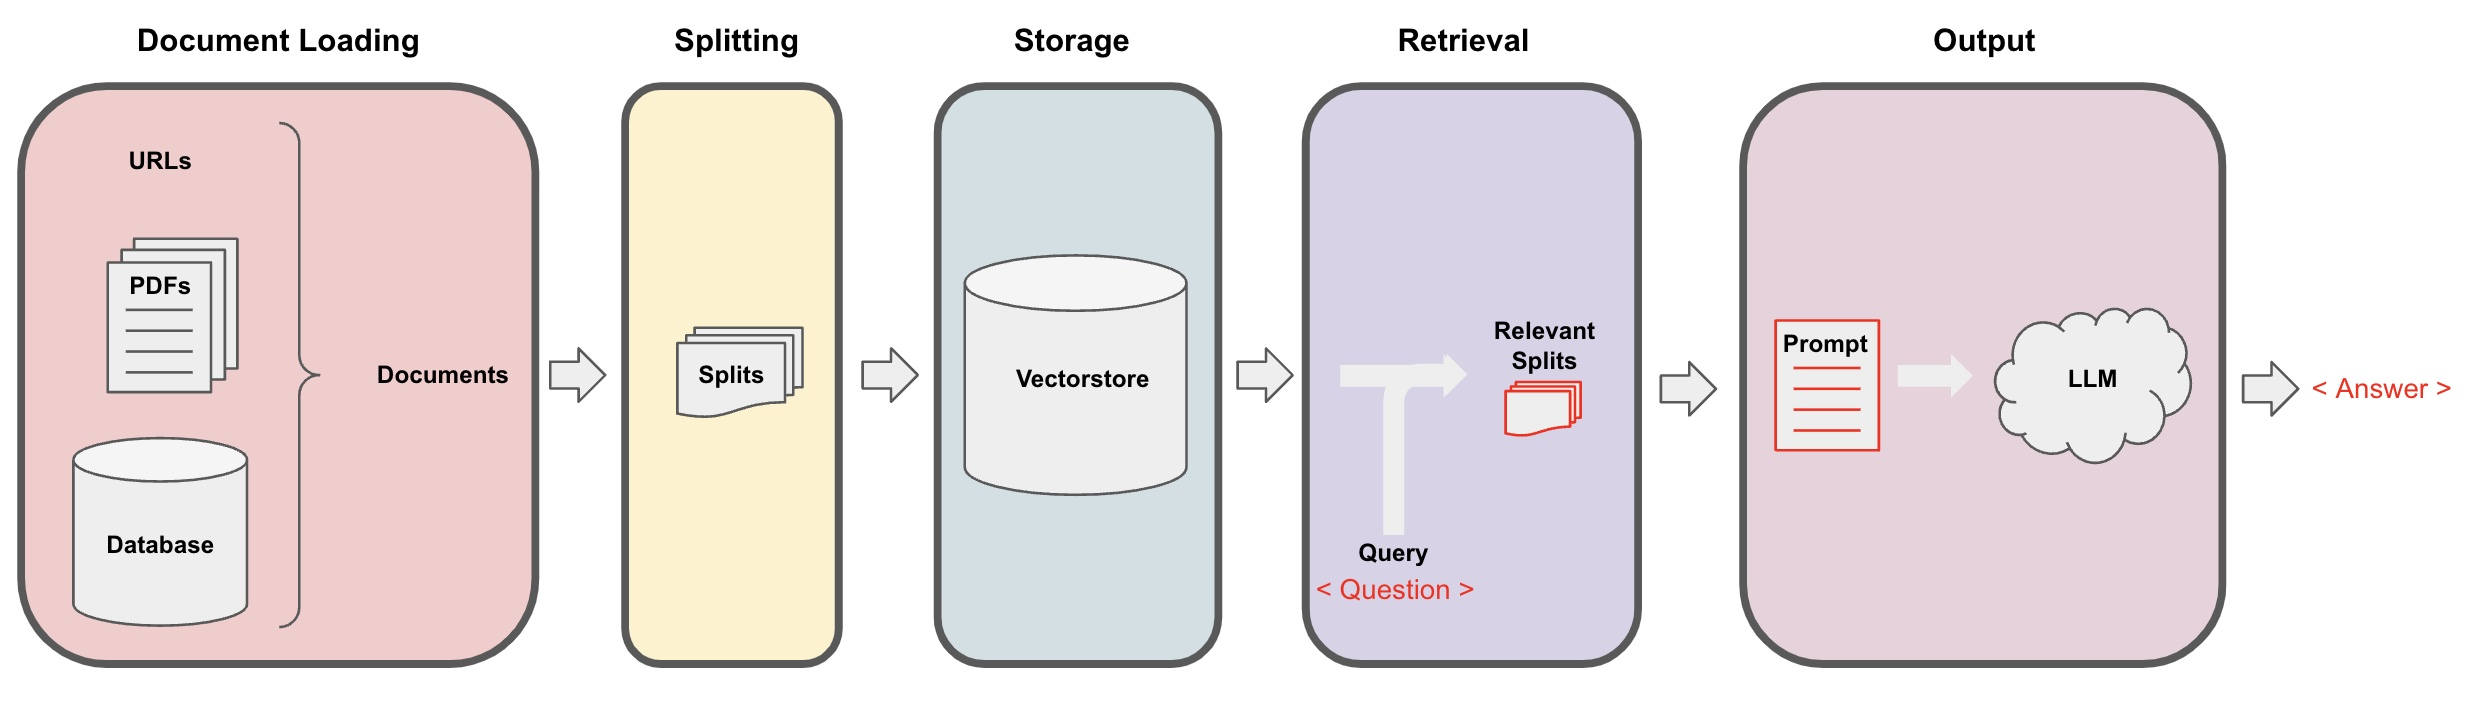

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB and ensure it works! 

In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
embd = OpenAIEmbeddings()
vectordb = FAISS.load_local("docs/cs229_lecture1_faiss_index",embd)

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

Great. Now, we want to somehow take these retrieved docs and distill it into an answer.

Here, we want to pipe together: 

* The retrieved docs 
* An LLM to summarize them into an answer to our question

We can use [many different LLMs](https://python.langchain.com/en/latest/modules/models/getting_started.html) in LangChain. 

Let's creat an LLM using OpenAI: 

* We can pick out version
* We can pick parameters, such as [temperature](https://platform.openai.com/docs/api-reference)

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm.predict("Hello world!")

Combining our docs with this LLM is where LangChain's chains come into play.

In particular, we can use `RetrievalQA` [chain](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html): 

* `llm` is our llm
* `retriever` is our vectorDB

In [ ]:
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectordb.as_retriever())
qa_chain.run(question)

Cool! So, under the hood we did a few things:
    
* Embedded the question
* Performed semantic similarity search on our embedded splits in the vectorDB based on the question
* Passed the retrieved splits to our LLM in a prompt
* Returned an answer
 
Now, we can peel back the onion. 

What exactly was the prompt!?

LangChain uses a default Q+A prompt with `RetrievalQA` [here](https://github.com/hwchase17/langchain/blob/master/langchain/chains/retrieval_qa/prompt.py).

But we can easily provide our own.


In [ ]:
from langchain.prompts import PromptTemplate
# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectordb.as_retriever(),chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})
qa_chain.run(question)

Note that there are some contraints:
    
This chain type expects `"context"` and `"question"` parameters in the prompt, because it's Q+A chain. 

The `context` is simply the contents of our returned docs.

Of course, we have the flexibility to modify anything else.

In addition, you can modify the how docs are used (see [here](https://docs.langchain.com/docs/components/chains/index_related_chains)).

In particular, 

* `chain_type=stuff` is the simplest method, simply stuffing all the retrieved docs into the prompt as context
* `chain_type=map_reduce` runs an initial prompt on each chunk of data and a different prompt is run to combine all the initial outputs

--- 

Now, let's do more.

Let's say we want to chat with the document.

We define a [memory buffer](https://python.langchain.com/en/latest/modules/chains/index_examples/chat_vector_db.html) and a `ConversationalRetrievalChain`.

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [ ]:
from langchain.chains import ConversationalRetrievalChain
qa = ConversationalRetrievalChain.from_llm(llm,retriever=vectordb.as_retriever(),memory=memory)

In [ ]:
question = "What did Professor Ng say about the class topics?"
result = qa({"question": question})

Now, we can see that the results has a `chat_history`.

In [ ]:
result

If we ask another question, we can see the prior chat history is preserved.

In [ ]:
question = "What did he say about the class prerequisites?"
qa({"question": question})

Now, again, let's play with the prompt.

TODO: Dig into [custom prompts](https://github.com/hwchase17/langchain/issues/2303).

In [ ]:
qa_new_prompt = ConversationalRetrievalChain.from_llm(llm,retriever=vectordb.as_retriever(),memory=memory,chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

## Evaluation

In this is prior notebooks, we presented one approach for RAG.

But, there are many different options: different split methods, split parameters, retrievers, and LLMs.

With this in mind, we have a tool that can help make sense of the choices called [auto-evaluator](https://github.com/langchain-ai/auto-evaluator/tree/main/api).

You can play with it here:

https://autoevaluator.langchain.com/

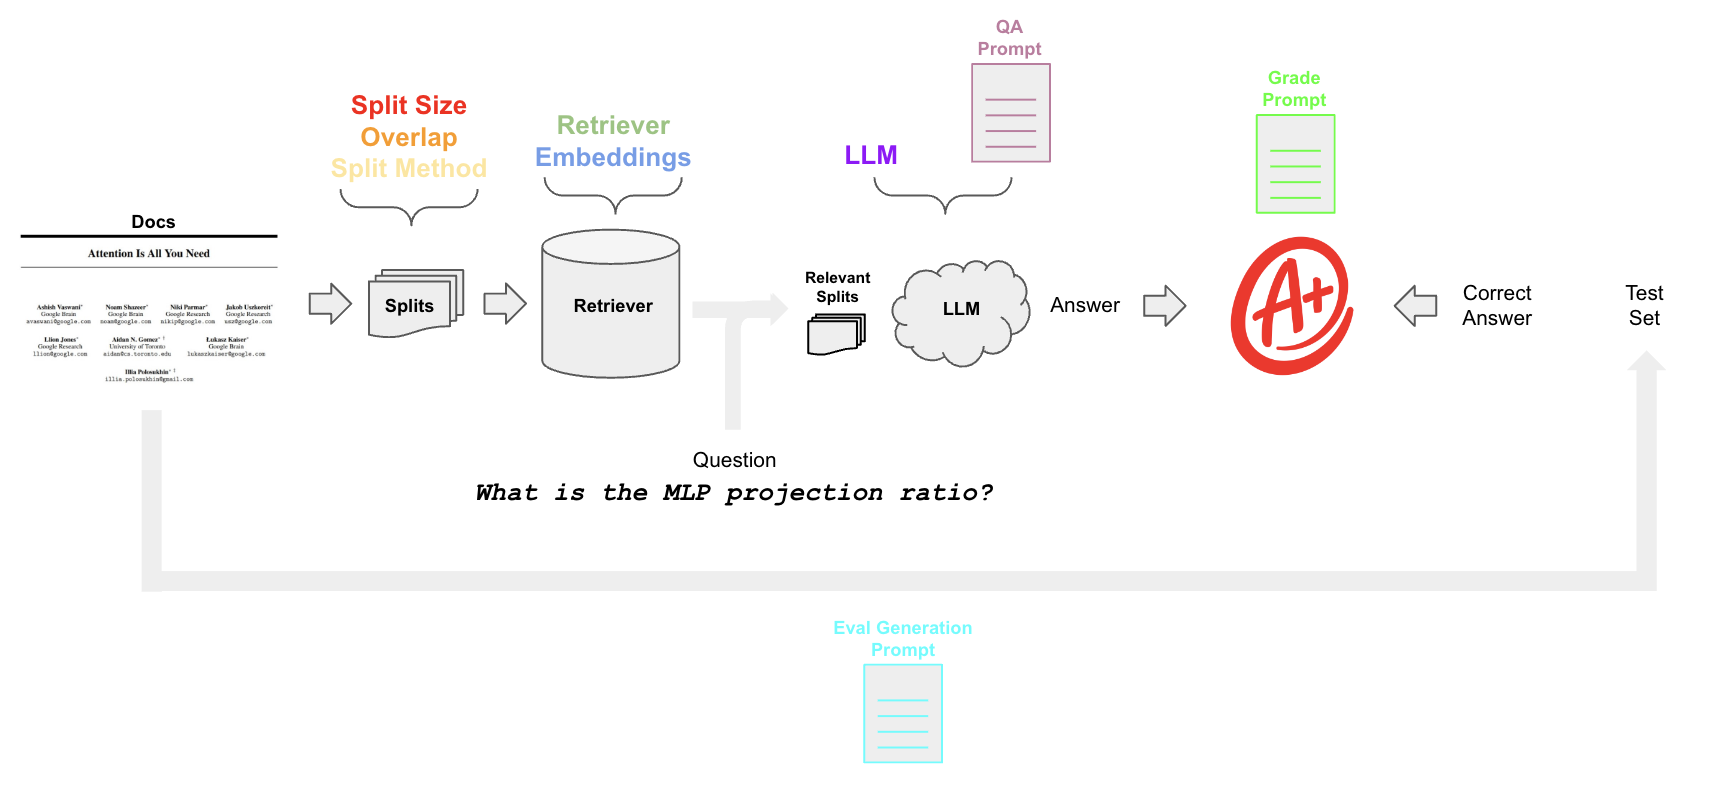

You can input a doc to the app, set your Q+A chain parameters, and see a grading of the resulting performance.